In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import datascience
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datascience import Table
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# A function to abstract the stock & trade data of a company for each year, month, and/or date
def stock_report(company, year, month = 0, day = 0):
    if month == 0:  
        rgx = "\d+\/\d+\/" + (str) (year % 100)
    elif day == 0:
        assert(1 <= month <= 12)
        rgx = (str) (month) + "\/\d+\/" + (str) (year % 100)
    else:
        
        return company.loc[company['Date'] == (str) (month) + "/" + (str) (day) + "/" + (str) (year % 100)]
    target = company['Date'].str.contains(rgx, regex = True)
    company['target'] = target
    company = company.loc[company['target'] == True]
    filtered_table = company.drop(columns = ['target']).reset_index().drop(columns = ['index'])
    return filtered_table

In [ ]:
def stock_report_after_n_days(company, n, date):
    stock_n_days = pd.DataFrame()
    index = company.index[company['Date'] == date][0]
    tbl = company.iloc[index: index + n + 1]
    return stock_n_days.append(tbl, ignore_index = True)

In [ ]:
def price_change(company, n, date):
    stock = stock_report_after_n_days(company, n, date)
    return ((stock.iloc[n, 4] - stock.iloc[0, 4]) / stock.iloc[0, 4]) * 100

In [ ]:
def volume_change(company, n, date):
    stock = stock_report_after_n_days(company, n, date)
    return ((stock.iloc[n, 3] - stock.iloc[0, 3]) / stock.iloc[0, 3]) * 100

In [ ]:
tweets = pd.read_csv('TweetsElonMusk.csv')
tweets = tweets[['date', 'tweet', 'likes_count']]
tweets["TweetsNoPunctuation"] = tweets['tweet'].str.replace('@\w+.', '', regex = True)
tweets['Mentioned_EV'] = tweets['TweetsNoPunctuation'].str.contains('[E|e]lectric Vehicle|[E|e]lectric|[B|b]attery|[L|l]ithium|AI|EV', regex = True)

tweets = tweets.drop(columns = ['tweet'])
tweets

,date,likes_count,TweetsNoPunctuation,Mentioned_EV
0,4/11/21,15281,For now. Costs are decreasing rapidly.,False
1,4/11/21,71161,Love this beautiful shot,False
2,4/11/21,1380,Trust the shrub,False
3,4/11/21,228144,The art In Cyberpunk is incredible,False
4,4/11/21,7489,🤣🤣,False
...,...,...,...,...
12557,4/14/21,2362,"Yeah, not scalable. My grad student idea was t...",False
12558,4/14/21,5209,That was my night job. Day job was working on ...,False
12559,4/14/21,46198,True. Ancient times … Had to flip CPU register...,False
12560,4/14/21,6051,Absolutely,False


In [ ]:
tesla = pd.read_csv('Stock_Report/tesla_stock.csv')
ford = pd.read_csv('Stock_Report/ford_stock.csv')
faraday = pd.read_csv('Stock_Report/faraday_stock.csv')

tesla['Average'] = (tesla[' High'] + tesla[' Low']) / 2
ford['Average'] = (ford[' High'] + ford[' Low']) / 2
faraday['Average'] = (faraday[' High'] + faraday[' Low']) / 2

tesla = tesla[['Date', ' High', ' Low', ' Volume', 'Average']]
ford = ford[['Date', ' High', ' Low', ' Volume', 'Average']]
faraday = faraday[['Date', ' High', ' Low', ' Volume', 'Average']]

In [ ]:
test = tweets.join(tesla.set_index('Date'), on = 'date').dropna()
test = test[['date', 'TweetsNoPunctuation', 'Mentioned_EV', 'Average']]

# A/B Testing Preparation

In [ ]:
EV_faraday = tweets.join(faraday.set_index('Date'), on = 'date').dropna().sort_values(by=['date']).reset_index(drop = True)
EV_faraday = EV_faraday[['date', 'TweetsNoPunctuation', 'Mentioned_EV', 'Average']]
EV_faraday['Stock price after a day (%)'] = [price_change(faraday, 1, date) for date in EV_faraday['date']]
EV_faraday['Volume after a day (%)'] = [volume_change(faraday, 1, date) for date in EV_faraday['date']]

analyzer = SentimentIntensityAnalyzer()
EV_faraday['Compound'] = [analyzer.polarity_scores(comment)['compound'] for comment in EV_faraday['TweetsNoPunctuation']]
EV_faraday

,date,TweetsNoPunctuation,Mentioned_EV,Average,Stock price after a day (%),Volume after a day (%),Compound
0,1/11/21,Already donated to Signal a year ago. Will don...,False,11.880,-1.893939,-65.048359,0.0000
1,1/11/21,A lot of people are going to be super unhappy ...,False,11.880,-1.893939,-65.048359,0.6597
2,1/11/21,I bought the replacement glass from a junkyard...,False,11.880,-1.893939,-65.048359,0.6249
3,1/11/21,Probably commenting on will do more,False,11.880,-1.893939,-65.048359,0.0000
4,1/11/21,The factory is the product,False,11.880,-1.893939,-65.048359,0.0000
...,...,...,...,...,...,...,...
1253,9/9/20,Yup,False,9.725,0.051414,17415.635101,0.0000
1254,9/9/20,"All Tesla workers also get stock, so their com...",False,9.725,0.051414,17415.635101,-0.2111
1255,9/9/20,Touché,False,9.725,0.051414,17415.635101,0.0000
1256,9/9/20,!,False,9.725,0.051414,17415.635101,0.0000


In [ ]:
EV_ford = tweets.join(ford.set_index('Date'), on = 'date').dropna().sort_values(by=['date']).reset_index(drop = True)
EV_ford = EV_ford[['date', 'TweetsNoPunctuation', 'Mentioned_EV', 'Average']]
EV_ford['Stock price after a day (%)'] = [price_change(ford, 1, date) for date in EV_ford['date']]
EV_ford['Volume after a day (%)'] = [volume_change(ford, 1, date) for date in EV_ford['date']]
EV_ford

analyzer = SentimentIntensityAnalyzer()
EV_ford['Compound'] = [analyzer.polarity_scores(comment)['compound'] for comment in EV_ford['TweetsNoPunctuation']]
EV_ford

,date,TweetsNoPunctuation,Mentioned_EV,Average,Stock price after a day (%),Volume after a day (%),Compound
0,1/10/19,Getting some regulatory pushback. May not be a...,False,8.610,2.380952,5.240402,0.0000
1,1/10/19,Tesla *with* Autopilot engaged is twice as saf...,False,8.610,2.380952,5.240402,0.7845
2,1/10/19,Def not,False,8.610,2.380952,5.240402,0.0000
3,1/10/19,Yes,False,8.610,2.380952,5.240402,0.4019
4,1/10/19,"Starting on Monday, Tesla will no longer be ta...",False,8.610,2.380952,5.240402,0.3818
...,...,...,...,...,...,...,...
6482,9/9/20,Yup,False,7.015,-0.890948,22.525389,0.0000
6483,9/9/20,13,False,7.015,-0.890948,22.525389,0.0000
6484,9/9/20,Rawlinson didn’t design Model S. Prototype was...,True,7.015,-0.890948,22.525389,-0.1855
6485,9/9/20,We’re pretty close to the manufacturing size l...,False,7.015,-0.890948,22.525389,0.8271


In [ ]:
EV_tesla = tweets.join(tesla.set_index('Date'), on = 'date').dropna().sort_values(by=['date']).sort_values(by=['date'])
EV_tesla = EV_tesla[['date', 'TweetsNoPunctuation', 'Mentioned_EV', 'Average']]
EV_tesla['Stock price after a day (%)'] = [price_change(tesla, 1, date) for date in EV_tesla['date']]
EV_tesla['Volume after a day (%)'] = [volume_change(tesla, 1, date) for date in EV_tesla['date']]
EV_tesla

analyzer = SentimentIntensityAnalyzer()
EV_tesla['Compound'] = [analyzer.polarity_scores(comment)['compound'] for comment in EV_tesla['TweetsNoPunctuation']]
EV_tesla

,date,TweetsNoPunctuation,Mentioned_EV,Average,Stock price after a day (%),Volume after a day (%),Compound
6981,1/10/19,Getting some regulatory pushback. May not be a...,False,67.718,1.476712,-16.797268,0.0000
6980,1/10/19,Yes,False,67.718,1.476712,-16.797268,0.4019
6992,1/10/19,"Plus, you can basically accelerate at the limi...",False,67.718,1.476712,-16.797268,0.0000
6982,1/10/19,Going through final validation &amp; regulator...,False,67.718,1.476712,-16.797268,0.5255
6983,1/10/19,Yes 🚀,False,67.718,1.476712,-16.797268,0.4019
...,...,...,...,...,...,...,...
1695,9/9/20,"All Tesla workers also get stock, so their com...",False,355.255,6.902084,6.876978,-0.2111
1696,9/9/20,Yup,False,355.255,6.902084,6.876978,0.0000
1697,9/9/20,13,False,355.255,6.902084,6.876978,0.0000
1698,9/9/20,Rawlinson didn’t design Model S. Prototype was...,True,355.255,6.902084,6.876978,-0.1855


In [ ]:
_deepnote_run_altair(EV_tesla, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"point","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"Compound","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"Stock price after a day (%)","type":"quantitative","sort":null,"scale":{"type":"linear","zero":false}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

# A/B Testing (Stock Price)

Null hypotheses: Elon Musk's tweets about EV do not affect the stock price of EV companies. Any observed differences was due to chance.

Alternative hypothesis: Elon Musk's tweets about EV increases the stock price of EV companies.

Test Statistic: Observed difference between the average of stock price change in percentage when Musk mentioned about EV and that of stock price change in percentage when he did not mentioned about EV.

2 categories for A/B testing: tweets about EV vs tweets not about EV

In [ ]:
def difference_of_means(table, group_label):
    table = table[[group_label, 'Shuffled_labels']]
    means_table = table.groupby(['Shuffled_labels']).mean()
    means = means_table.iloc[:, 0]
    return means[1] - means[0]

In [ ]:
def AB_testing(table, group_label, repetition):
    result = []
    for _ in range(repetition):
        table['Shuffled_labels'] = np.random.permutation(table['Mentioned_EV'].values)
        result = np.append(result, difference_of_means(table, group_label))
    return result

In [ ]:
tesla_observed_statistics = np.average(EV_tesla.loc[EV_tesla['Mentioned_EV'] == True]['Stock price after a day (%)']) - np.average(EV_tesla.loc[EV_tesla['Mentioned_EV'] == False]['Stock price after a day (%)'])
ford_observed_statistics = np.average(EV_ford.loc[EV_ford['Mentioned_EV'] == True]['Stock price after a day (%)']) - np.average(EV_ford.loc[EV_ford['Mentioned_EV'] == False]['Stock price after a day (%)'])
faraday_observed_statistics = np.average(EV_faraday.loc[EV_faraday['Mentioned_EV'] == True]['Stock price after a day (%)']) - np.average(EV_faraday.loc[EV_faraday['Mentioned_EV'] == False]['Stock price after a day (%)'])
[tesla_observed_statistics, ford_observed_statistics, faraday_observed_statistics]

[-0.24594929155386092, -0.046700521473447415, 0.33542591358163243]

In [ ]:
faraday_result = AB_testing(EV_faraday, 'Stock price after a day (%)', 1000)
ford_result = AB_testing(EV_ford, 'Stock price after a day (%)', 1000)
tesla_result = AB_testing(EV_tesla, 'Stock price after a day (%)', 1000)

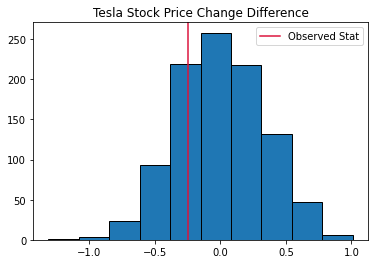

In [ ]:
plt.hist(tesla_result)
plt.title('Tesla Stock Price Change Difference')
l = plt.axvline(tesla_observed_statistics, color="crimson")
plt.legend([l], ["Observed Stat"], loc=1)
plt.show()

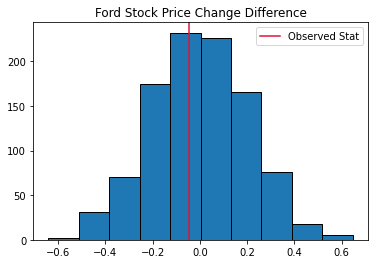

In [ ]:
plt.hist(ford_result)
plt.title('Ford Stock Price Change Difference')
l = plt.axvline(ford_observed_statistics, color="crimson")
plt.legend([l], ["Observed Stat"], loc=1)
plt.show()

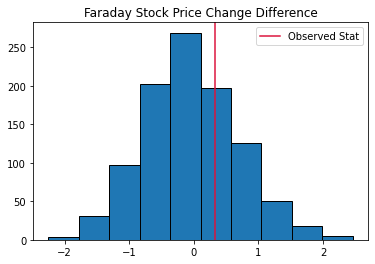

In [ ]:
plt.hist(faraday_result)
plt.title('Faraday Stock Price Change Difference')
l = plt.axvline(faraday_observed_statistics, color="crimson")
plt.legend([l], ["Observed Stat"], loc=1)
plt.show()

In [ ]:
p_tsla = sum(tesla_result >= tesla_observed_statistics) / len(tesla_result)
p_f = sum(ford_result >= ford_observed_statistics) / len(ford_result)
p_fr = sum(faraday_result >= faraday_observed_statistics) / len(ford_result)
print("p-value of Tesla stock change: {}".format(p_tsla))
print("p-value of Ford stock change: {}".format(p_f))
print("p-value of Faraday stock change: {}".format(p_fr))

p-value of Tesla stock change: 0.76
p-value of Ford stock change: 0.573
p-value of Faraday stock change: 0.3


# A/B Testing (Stock Volume)

&nbsp;Null Hypothesis: Elon Musk's tweets about EV do not affect the "volume (The amount of stock traded)" of EV companies. Any observed differences was due to chance.

Alternative Hypothesis: Elon Musk's tweets about EV increases the stock volume of EV companies.

Test Statistic: Observed difference between the average of stock volume change in percentage when Musk mentioned about EV and that of volume change in percentage when he did not mentioned about EV.

In [ ]:
tesla_v_observed_statistics = np.average(EV_tesla.loc[EV_tesla['Mentioned_EV'] == True]['Volume after a day (%)']) - np.average(EV_tesla.loc[EV_tesla['Mentioned_EV'] == False]['Volume after a day (%)'])
ford_v_observed_statistics = np.average(EV_ford.loc[EV_ford['Mentioned_EV'] == True]['Volume after a day (%)']) - np.average(EV_ford.loc[EV_ford['Mentioned_EV'] == False]['Volume after a day (%)'])
faraday_v_observed_statistics = np.average(EV_faraday.loc[EV_faraday['Mentioned_EV'] == True]['Volume after a day (%)']) - np.average(EV_faraday.loc[EV_faraday['Mentioned_EV'] == False]['Volume after a day (%)'])
[tesla_v_observed_statistics, ford_v_observed_statistics, faraday_v_observed_statistics]

[4.800836286844174, -3.0037868728666686, 549.799599028805]

In [ ]:
ford_volume = AB_testing(EV_ford, 'Volume after a day (%)', 1000)
faraday_volume = AB_testing(EV_faraday, 'Volume after a day (%)', 1000)
tesla_volume = AB_testing(EV_tesla, 'Volume after a day (%)', 1000)

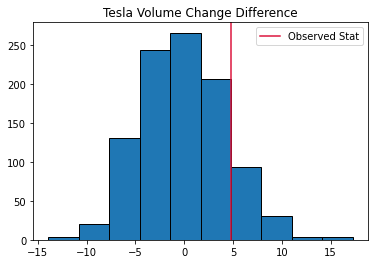

In [ ]:
plt.hist(tesla_volume)
plt.title('Tesla Volume Change Difference')
l = plt.axvline(tesla_v_observed_statistics, color="crimson")
plt.legend([l], ["Observed Stat"], loc=1)
plt.show()

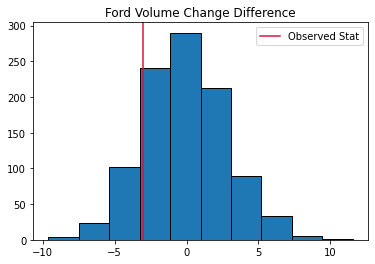

In [ ]:
plt.hist(ford_volume)
plt.title('Ford Volume Change Difference')
l = plt.axvline(ford_v_observed_statistics, color="crimson")
plt.legend([l], ["Observed Stat"], loc=1)
plt.show()

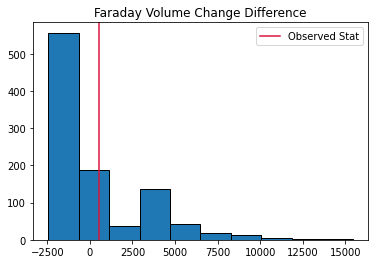

In [ ]:
plt.hist(faraday_volume)
plt.title('Faraday Volume Change Difference')
l = plt.axvline(faraday_v_observed_statistics, color="crimson")
plt.legend([l], ["Observed Stat"], loc=1)
plt.show()

In [ ]:
p_v_tsla = sum(tesla_volume >= tesla_v_observed_statistics) / len(tesla_volume)
p_v_f = sum(ford_volume >= ford_v_observed_statistics) / len(ford_volume)
p_v_fr = sum(faraday_volume >= faraday_v_observed_statistics) / len(faraday_volume)
print("p-value of Tesla volume change: {}".format(p_v_tsla))
print("p-value of Ford volume change: {}".format(p_v_f))
print("p-value of Faraday volume change: {}".format(p_v_fr))

p-value of Tesla volume change: 0.13
p-value of Ford volume change: 0.853
p-value of Faraday volume change: 0.27


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d398409d-5f29-4a0e-acc8-f3319fb703e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>